In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import pickle
X = pd.read_pickle('Data/Mnist/X.pickle')
y= pd.read_pickle('Data/Mnist/y.pickle')

In [29]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [30]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

x_train.shape: (60000, 28, 28)


In [31]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [32]:
# Dimensionality of the latent space
latent_dim = 100

In [33]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [34]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [35]:
# Compile both models in preparation for training


# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [36]:
# Train the GAN


# Config
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [37]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [38]:
# Main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.86,       d_acc: 0.12, g_loss: 0.79
epoch: 101/30000, d_loss: 0.08,       d_acc: 1.00, g_loss: 3.52
epoch: 201/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 1.03
epoch: 301/30000, d_loss: 0.72,       d_acc: 0.47, g_loss: 0.60
epoch: 401/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.64
epoch: 501/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.67
epoch: 601/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.67
epoch: 701/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.67
epoch: 801/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.69
epoch: 901/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.71
epoch: 1001/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.75
epoch: 1101/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.75
epoch: 1201/30000, d_loss: 0.64,       d_acc: 0.70, g_loss: 0.74
epoch: 1301/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.79
epoch: 1401/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.71
epoch: 1501/30000, d_loss: 0.66,     

epoch: 12601/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.77
epoch: 12701/30000, d_loss: 0.70,       d_acc: 0.50, g_loss: 0.80
epoch: 12801/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.82
epoch: 12901/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.79
epoch: 13001/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.77
epoch: 13101/30000, d_loss: 0.68,       d_acc: 0.48, g_loss: 0.80
epoch: 13201/30000, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.82
epoch: 13301/30000, d_loss: 0.66,       d_acc: 0.62, g_loss: 0.78
epoch: 13401/30000, d_loss: 0.64,       d_acc: 0.66, g_loss: 0.82
epoch: 13501/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.83
epoch: 13601/30000, d_loss: 0.70,       d_acc: 0.52, g_loss: 0.78
epoch: 13701/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.74
epoch: 13801/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.79
epoch: 13901/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.75
epoch: 14001/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.75
epoch: 141

epoch: 25101/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.80
epoch: 25201/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.80
epoch: 25301/30000, d_loss: 0.65,       d_acc: 0.59, g_loss: 0.81
epoch: 25401/30000, d_loss: 0.67,       d_acc: 0.52, g_loss: 0.79
epoch: 25501/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.79
epoch: 25601/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.78
epoch: 25701/30000, d_loss: 0.71,       d_acc: 0.42, g_loss: 0.77
epoch: 25801/30000, d_loss: 0.65,       d_acc: 0.64, g_loss: 0.76
epoch: 25901/30000, d_loss: 0.72,       d_acc: 0.45, g_loss: 0.80
epoch: 26001/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.77
epoch: 26101/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.79
epoch: 26201/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.79
epoch: 26301/30000, d_loss: 0.65,       d_acc: 0.67, g_loss: 0.76
epoch: 26401/30000, d_loss: 0.72,       d_acc: 0.36, g_loss: 0.79
epoch: 26501/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.77
epoch: 266

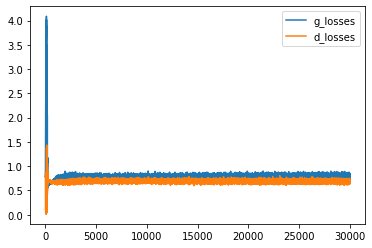

In [39]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

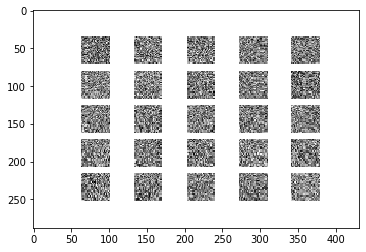

In [40]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

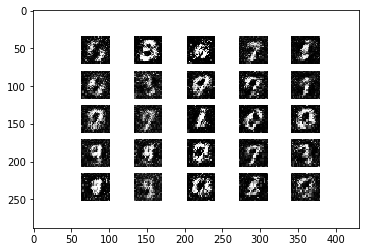

In [41]:
a = imread('gan_images/1000.png')
plt.imshow(a)

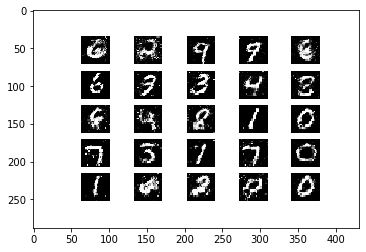

In [42]:
a = imread('gan_images/5000.png')
plt.imshow(a)

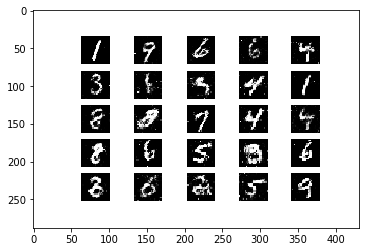

In [43]:
a = imread('gan_images/10000.png')
plt.imshow(a)

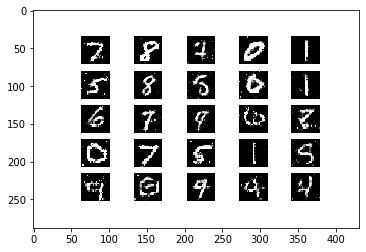

In [44]:
a = imread('gan_images/29800.png')
plt.imshow(a)